<a href="https://colab.research.google.com/github/SaraiEscatel/AnalizadorLexico/blob/main/Hands_on_4_Polynomial_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score


# Opciones de visualización
%matplotlib inline
sns.set(style='whitegrid')


In [ ]:
# Celda 2 - Generar un dataset sintético
# Aquí generamos datos con una relación polinómica (grado 3) + ruido.
np.random.seed(42)
X = np.linspace(-3, 3, 100).reshape(-1, 1)
y_true = 0.5 * X.ravel()**3 - X.ravel()**2 + 2 * X.ravel() + 3
noise = np.random.normal(scale=5, size=X.shape[0])
y = y_true + noise

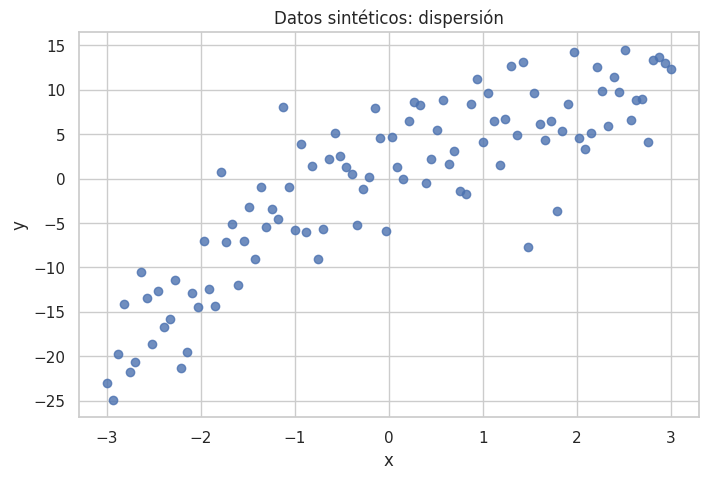

In [ ]:
# DataFrame auxiliar para visualización
df = pd.DataFrame({'x': X.ravel(), 'y': y})


plt.figure(figsize=(8,5))
plt.scatter(df['x'], df['y'], alpha=0.8)
plt.title('Datos sintéticos: dispersión')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [ ]:
# Celda 3 - División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [ ]:
# Celda 4 - Pipeline básico: PolynomialFeatures + LinearRegression (sin regularizar)
pipeline_lr = Pipeline([
('poly', PolynomialFeatures(degree=3, include_bias=False)),
('scaler', StandardScaler()),
('linreg', LinearRegression())
])


pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [ ]:
# Predicción y métricas
y_pred_train = pipeline_lr.predict(X_train)
y_pred_test = pipeline_lr.predict(X_test)


print('OLS Polynomial (degree=3) — Train MSE:', mean_squared_error(y_train, y_pred_train))
print('OLS Polynomial (degree=3) — Test MSE:', mean_squared_error(y_test, y_pred_test))
print('Test R2:', r2_score(y_test, y_pred_test))

OLS Polynomial (degree=3) — Train MSE: 19.356333914668035
OLS Polynomial (degree=3) — Test MSE: 21.661156462393823
Test R2: 0.8280388213357756


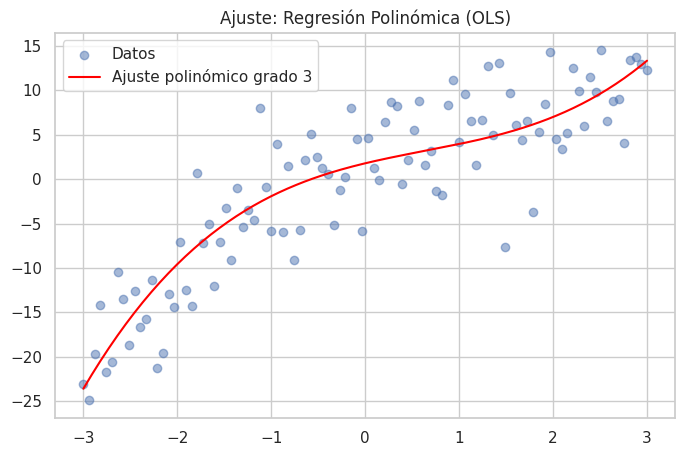

In [ ]:
# Celda 5 - Visualizar la curva ajustada
X_plot = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
y_plot = pipeline_lr.predict(X_plot)


plt.figure(figsize=(8,5))
plt.scatter(X, y, label='Datos', alpha=0.5)
plt.plot(X_plot, y_plot, color='red', label='Ajuste polinómico grado 3')
plt.legend()
plt.title('Ajuste: Regresión Polinómica (OLS)')
plt.show()

In [ ]:
# Celda 6 - Búsqueda de hiperparámetros: probar distintos grados y regularización (Ridge)
pipe = Pipeline([
('poly', PolynomialFeatures(include_bias=False)),
('scaler', StandardScaler()),
('ridge', Ridge())
])


param_grid = {
'poly__degree': [1,2,3,4,5,6],
'ridge__alpha': [0.01, 0.1, 1, 10, 100]
}


grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)


print('Mejores parámetros:', grid.best_params_)
print('Mejor score (neg MSE):', grid.best_score_)

Mejores parámetros: {'poly__degree': 3, 'ridge__alpha': 1}
Mejor score (neg MSE): -22.43951850488315


Test MSE (mejor modelo): 21.832774863131412
Test R2 (mejor modelo): 0.826676396272158


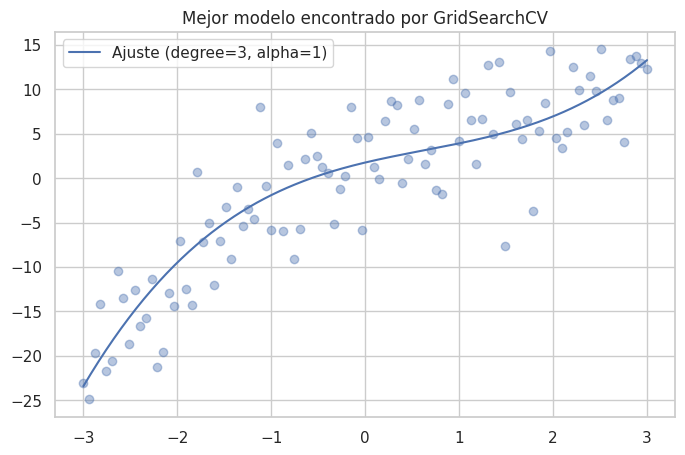

In [ ]:
# Celda 7 - Evaluar mejor modelo en test
best_model = grid.best_estimator_


y_test_pred = best_model.predict(X_test)
print('Test MSE (mejor modelo):', mean_squared_error(y_test, y_test_pred))
print('Test R2 (mejor modelo):', r2_score(y_test, y_test_pred))


# Visualizar
X_plot = np.linspace(X.min(), X.max(), 300).reshape(-1,1)
y_plot = best_model.predict(X_plot)


plt.figure(figsize=(8,5))
plt.scatter(X, y, alpha=0.4)
plt.plot(X_plot, y_plot, label=f'Ajuste (degree={grid.best_params_["poly__degree"]}, alpha={grid.best_params_["ridge__alpha"]})')
plt.legend()
plt.title('Mejor modelo encontrado por GridSearchCV')
plt.show()

In [ ]:
# Celda 8 - Interpretación de coeficientes (si aplica)
# Si el modelo es un Pipeline con PolynomialFeatures + Ridge, extraemos coeficientes
poly = best_model.named_steps['poly']
ridge = best_model.named_steps['ridge']


feature_names = poly.get_feature_names_out(['x'])
coefs = ridge.coef_


coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
coef_df

,feature,coef
0,x,4.281872
1,x^2,-2.083283
2,x^3,4.122709


In [ ]:
# Celda 9 - Guardar modelo (opcional)
import joblib
joblib.dump(best_model, 'modelo_regresion_polinomica_best.pkl')

['modelo_regresion_polinomica_best.pkl']

In [ ]:
# Celda 10 - Predicción con nuevos datos (ejemplo)
X_new = np.array([[-2.5], [0.0], [1.5], [2.8]])
predictions = best_model.predict(X_new)
for xi, yi in zip(X_new.ravel(), predictions):
   print(f'x={xi:.2f} -> y_pred={yi:.3f}')

x=-2.50 -> y_pred=-15.529
x=0.00 -> y_pred=1.754
x=1.50 -> y_pred=5.168
x=2.80 -> y_pred=11.636
